# Investigate spatial outliers

We take a look at all structures that contain residues (CA atoms) with a distance to the `kissim` subpocket centers below/above a certain minimum/maximum cutoff. 

This allows us to identify outlier structures that we want to exclude from our dataset (in our `kissim` pipeline this is done with the `kissim outlier` CLI).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# from opencadd.structure.pocket import PocketKlifs, PocketViewer
from opencadd.databases.klifs import setup_remote

from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/all"

In [5]:
REMOTE = setup_remote()

## Set distance minimum/maximum cutoffs

These cutoffs define spatial outliers.

In [6]:
DISTANCE_CUTOFFS = {
    "hinge_region": (1, 34),
    "dfg_region": (1, 34),
    "front_pocket": (1, 34),
    "center": (1, 34),
}
print(
    f"Use the following distance minimum/maximum cutoffs"
    f" to identify outlier structures: {DISTANCE_CUTOFFS}"
)

Use the following distance minimum/maximum cutoffs to identify outlier structures: {'hinge_region': (1, 34), 'dfg_region': (1, 34), 'front_pocket': (1, 34), 'center': (1, 34)}


## Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [7]:
fingerprint_generator = FingerprintGenerator.from_json(
    RESULTS / "fingerprints.json", normalize=True
)
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4623


## Get distance features

Lets load distances (from each residue to each subpocket center) for all fingerprints.

In [8]:
distances = fingerprint_generator.distances_exploded()
distances

hinge_region  dfg_region  front_pocket  \
structure_klifs_id residue_ix                                           
1                  1              13.453884   18.280884     14.480577   
                   2              12.553288   15.885122     12.370021   
                   3              10.540322   14.686474      9.160533   
                   4              10.875768   12.470337      8.180632   
                   5              13.355084   12.179722     10.597742   
...                                     ...         ...           ...   
13740              81              8.176181    6.305268      6.473903   
                   82             10.908327    6.283243     10.256677   
                   83             12.301838    4.710865     10.973125   
                   84             15.421875    8.506138     13.081077   
                   85             15.769991    9.725726     14.484319   

                                  center  
structure_klifs_id residue_ix             
1                  1           17.260859  
                   2           15.571550  
                   3           13.120049  
                   4           12.173719  
                   5           13.909365  
...                                  ...  
13740              81           2.834086  
                   82           5.545019  
                   83           7.593192  
                   84          10.190306  
                   85          10.333244  

[392955 rows x 4 columns]

In [9]:
distances.describe()

,hinge_region,dfg_region,front_pocket,center
count,387959.000000,385252.000000,387959.000000,387959.000000
mean,12.869833,13.555590,13.026229,11.998166
std,4.561533,4.853862,4.284138,3.475858
min,2.373261,0.873535,1.355564,1.001008
25%,9.569334,9.913790,9.848150,9.902786
50%,12.566377,13.282713,12.446102,12.010692
75%,15.967597,16.711250,16.162168,13.671944
max,30.791023,33.577599,33.154510,26.890888


## Get structures with extreme distances

Let's plot distance histograms (over all residue positions) per subpocket center and retain only extreme distances.

In [10]:
def extreme_distances(distances, feature_type, distance_cutoffs):

    cutoff_min = distance_cutoffs[feature_type][0]
    cutoff_max = distance_cutoffs[feature_type][1]

    features = distances[feature_type]
    range_full = round(features.max() - features.min(), 2)
    features_min = features[features < cutoff_min]
    features_max = features[features > cutoff_max]
    range_min_max = cutoff_max - cutoff_min
    n_structures_below_min = len(features_min.reset_index()["structure_klifs_id"].unique())
    n_structures_above_max = len(features_max.reset_index()["structure_klifs_id"].unique())
    n_residues_below_min = len(features_min.reset_index()["residue_ix"].unique())
    n_residues_above_max = len(features_max.reset_index()["residue_ix"].unique())
    range_below_min = round(features_min.max() - features_min.min(), 2)
    range_above_max = round(features_max.max() - features_max.min(), 2)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
    fig.suptitle(f"Extreme distances seen in subpocket {feature_type}", fontsize="x-large")
    axes[0].axvspan(cutoff_min, cutoff_max, color="cyan", alpha=0.1)
    features.plot(
        kind="hist",
        bins=100,
        ax=axes[0],
        title=f"All structures (full range {range_full} A, cutoff range {range_min_max} A / cyan)",
    )
    features_min.plot(
        kind="hist",
        ax=axes[1],
        title=f"Below {cutoff_min} A: #{n_structures_below_min} structures |"
        f" #{n_residues_below_min} residue positions (range {range_below_min} A)",
    )
    features_max.plot(
        kind="hist",
        ax=axes[2],
        title=f"Above {cutoff_max} A: #{n_structures_above_max} structures |"
        f" #{n_residues_above_max} residue positions (range {range_above_max} A)",
    )

    return features_min, features_max

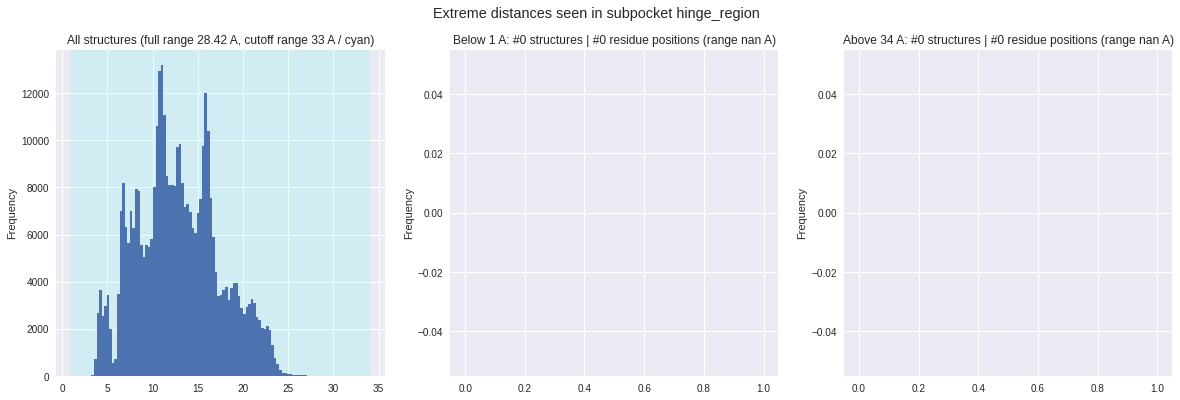

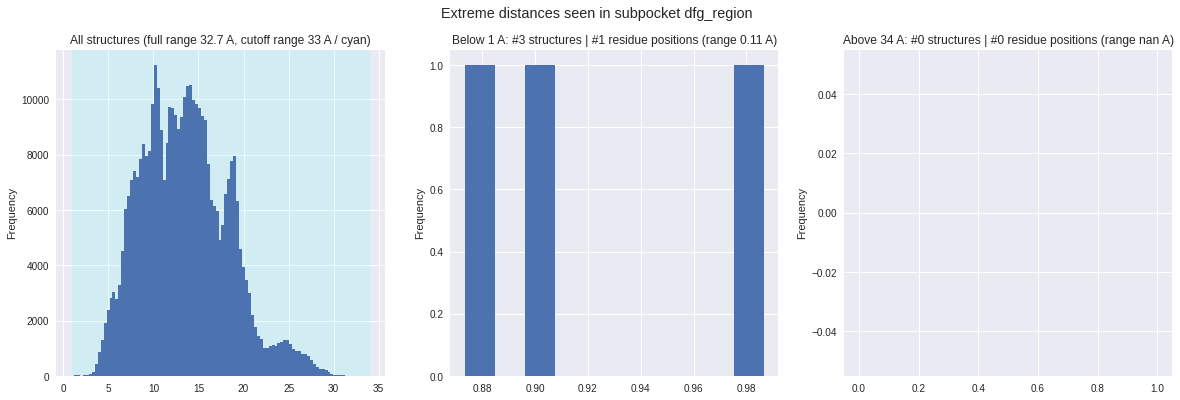

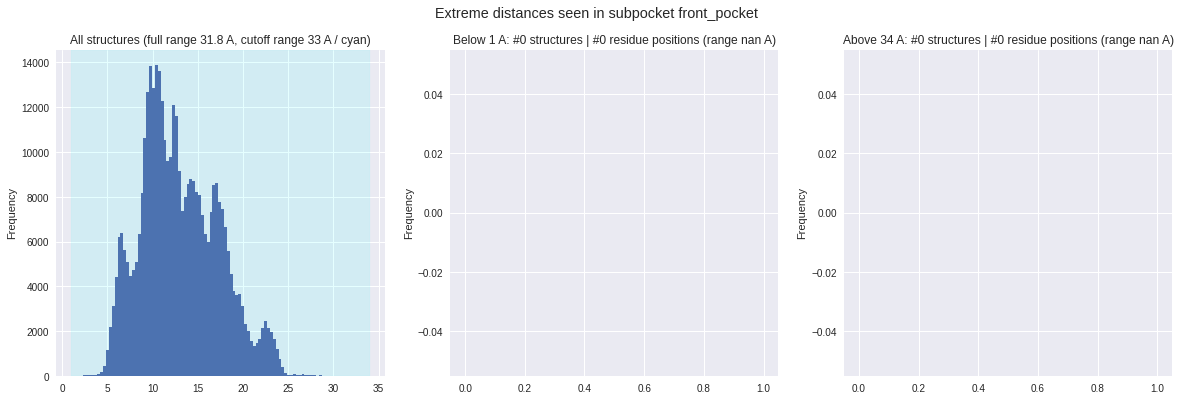

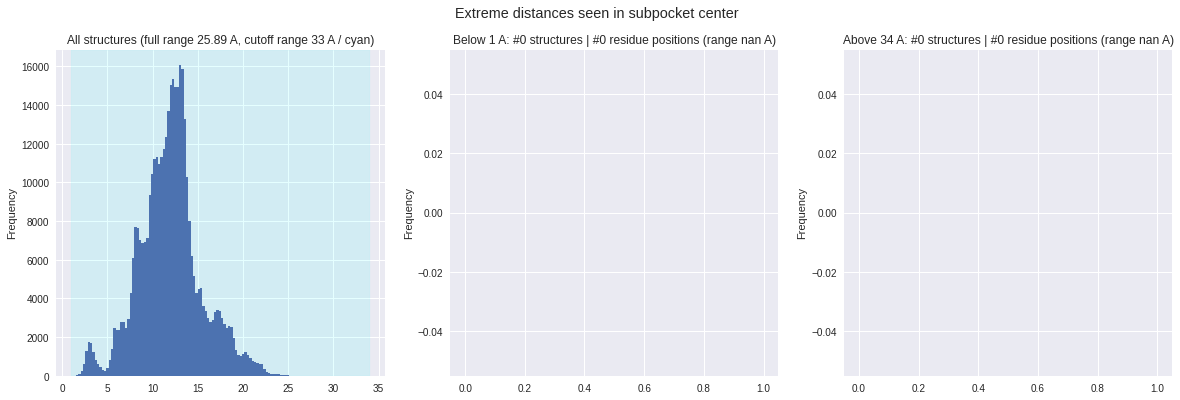

In [11]:
extreme_features = {}
for feature_type, _ in distances.items():
    features_min, features_max = extreme_distances(distances, feature_type, DISTANCE_CUTOFFS)
    extreme_features[feature_type] = (features_min, features_max)

__Note__: We will not define a minimum cutoff because it is possible that a subpocket center sits very closely to a residue CA atom and thus, in this case we would not speak of an outlier. In the following we will only focus on the long distances outliers.

### Pocket center

In [12]:
extreme_features["center"][1]

Series([], Name: center, dtype: float64)

In [13]:
extreme_features["center"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

### Front pocket

In [14]:
extreme_features["front_pocket"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [15]:
extreme_features["front_pocket"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

### Hinge region

In [16]:
extreme_features["hinge_region"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [17]:
extreme_features["hinge_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

### DFG region

In [18]:
extreme_features["dfg_region"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [19]:
extreme_features["dfg_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

## Look at structures with extremely long distances

In [20]:
extreme_structures_max = []
for subpocket_name, features in extreme_features.items():
    extreme_structures_max.extend(
        features[1].index.get_level_values("structure_klifs_id").unique()
    )
extreme_structures_max = set(extreme_structures_max)

print(f"Structures with extremly long distances: {extreme_structures_max}")

Structures with extremly long distances: set()
